In [57]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.datasets import DatasetFolder
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [58]:
transform = transforms.ToTensor()

batch_size = 4
num_workers = 2

In [59]:
images = 'drumsdataset/mel_img'
dataset = datasets.ImageFolder(root = images, transform = transform)



In [60]:
#split train/test data
train = int(0.8 * len(dataset))
test = len(dataset) - train

train, test = random_split(dataset, [train, test])

In [61]:
train_loader = DataLoader(train, batch_size = batch_size, shuffle = True, num_workers = num_workers)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False, num_workers = num_workers)


classes = ('cymbal', 'kick', 'snare', 'tom') #in order of folders

cymbal   tom  kick cymbal


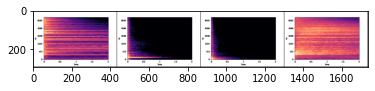

In [62]:
def imgshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    
dataiter = iter(train_loader)
images, labels = next(dataiter)

imgshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [63]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #in_channels = 3: RGB
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(115920, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [64]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=115920, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
)


In [65]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [77]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


GroundTruth: snare cymbal kick kick
Predicted: snare cymbal kick kick


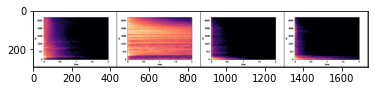

In [78]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imgshow(torchvision.utils.make_grid(images))
print('GroundTruth:', ' '.join('%s' % classes[labels[j]] for j in range(4)))

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted:', ' '.join('%s' % classes[predicted[j]] for j in range(4)))

In [79]:
acc = 0
count = 0
predlst = []
truth = []
for inputs, labels in test_loader:
    outputs = net(inputs)
    acc += (torch.argmax(outputs, 1) == labels).float().sum()
    count += len(labels)
    _, pred = torch.max(outputs, 1)
    predlst.extend(pred.tolist())
    truth.extend(labels.tolist())
acc /= count
print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))

Epoch 9: model accuracy 96.88%


In [80]:
import pandas as pd
df = pd.DataFrame({'pred':predlst, 'true':truth})
df.head()

,pred,true
0,2,2
1,0,0
2,1,1
3,1,1
4,2,2


In [81]:
from sklearn.metrics import confusion_matrix

def conf(truth, pred, classes):
    
    #confusion matrix
    conf = pd.DataFrame(confusion_matrix(truth, pred))
    conf.columns = classes
    conf.index = classes
    
    #accuracy column
    cymacc = conf['cymbal'][0] / int(sum(conf.loc['cymbal']))
    kickacc = conf['kick'][1] / int(sum(conf.loc['kick']))
    snareacc = conf['snare'][2] / int(sum(conf.loc['snare']))
    tomacc = conf['tom'][3] / int(sum(conf.loc['tom']))

    acc = [cymacc, kickacc, snareacc, tomacc]
    conf['acc'] = acc
    
    return(conf)


conf(truth, predlst, classes)

,cymbal,kick,snare,tom,acc
cymbal,8,0,0,0,1.000000
kick,0,11,0,0,1.000000
snare,0,0,6,1,0.857143
tom,0,0,0,6,1.000000
